<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/load_synapses/notebooks/AA_pre_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There is some initial setup for Colab or server use.

In [1]:
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab

This notebook will be used to design your simulation before simulating.

In [2]:
# install repo and packages if running in Google Colab
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:
    !git clone https://github.com/davidfague/Neural-Modeling.git -b load_synapses
    !pip install neuron
    !pip install neuron_reduce
    !pip install allensdk

In Colab you will get a prompt about the session being initialized with a different numpy version than the one that was just installed. 

Click OK then run the next cell.

In [3]:
# install versions needed for package. Restart Colab session to use these versions.
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:
    !pip install --upgrade numpy==1.24.4 pandas==2.2.2 scipy==1.11.3> /dev/null 2>&1

    import os
    os.kill(os.getpid(), 9)#restart so the above packages can be used

Then your session will 'crash' to enable the use of these versions in Colab and you can run the rest of the cells:

In [4]:
if RunningInCOLAB:
    os.chdir('Neural-Modeling/notebooks')

load modfiles

In [5]:
from neuron import h
h.load_file('stdrun.hoc') # load some NEURON standard functions (nrnivmodl, h.nrn_load_dll, etc.)

--No graphics will be displayed.


1.0

In [6]:
if not os.path.exists('x86_64'):
  !nrnivmodl '../modfiles/hay' # compile the mod files

In [7]:
if not os.path.exists('x86_64'): # check if this condition is necessary
  h.nrn_load_dll('x86_64/.libs/libnrnmech.so') # load the compiled mod files into neuron

Import modules and prepare to import modules from the repo (stored in Neural-Modleing/Modules/).

In [8]:
import sys
sys.path.append('../')
sys.path.append('../Modules/')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(os.getcwd()) # print the current working directory before changing
if 'notebook' in os.getcwd():
    os.chdir("../simulations") # go from Neural-Modeling/notebooks to Neural-Modeling/simulations, where simulation outputs will be generated to.
    print(os.getcwd()) # print the current working directory to confirm the change

/home/drfrbc/Neural-Modeling/notebooks
/home/drfrbc/Neural-Modeling/simulations


## User Specifications -  parameters, simulation folder

### Parameters

Here you can define your own parameters to use for designing the simulation and the simulation itself. 

The defaults are HayParameters, which is a dataclass stored in Neural-Modeling/Modules/constants.py.

To use your own parameters, simply initialize HayParameters with the values you would like to change them to.

Example 1, I've store a clustering config "exc_clustering" in another file called Modules.clusters. I imported the variable "exc_clustering" and called 

        parameters = HayParameters(..., 

                                    exc_clustering=exc_clustering, 

                                    ...) 

so that parameters.exc_clustering is the imported exc_clustering instead of the default HayParameters.exc_clustering (stored in Modules.constants.py)

Example 2, I've stored a dictionary of simulation configs, "sim_type_params_all" in Neural-Modeling/scripts/gen_param_list_advanced.py, and specified the key ('sim_type') to use. Then, sim_type_params_all[{sim_type}] accesses a small dictionary specying parameters and their values *to overwrite*

Calling:

        parameters = HayParameters(..., 

                                    **sim_type_params_all[sim_type],

                                    ...)

using ** passes all the (key, value) pairs in the sim_type_params_all[sim_type] dictionary as argument=value (key=value) pairs to HayParameters().

### Simulation directories

The format for simulation directories is: 

        "Neural-Modeling/simulations/{simulations_folder}/{simulation_folder}" or in short "Neural-Modeling/simulations/{sims_dir}/{sim_dir}"

Brackets, { }, are used to indicate the folders that you will name.

There is a folder for all simulations:
    
        "Neural-Modeling/simulations/"

A folder within simulations/ for a group of designed simulations:
        
        "Neural-Modeling/simulations/{sims_dir}/" (for example when you run a parametric analysis and need to analyze a certain group of simulations)

and a folder within {sims_dir}/ for each individual simulation:

        "Neural-Modeling/simulations/{sims_dir}/{sim_dir}/" (to hold the individual simulation parameters, data, etc.)

In [9]:
from Modules.constants import HayParameters
import datetime
import pickle
from neuron import h

from Modules.simulation_slurm import Simulator

from scripts.gen_param_list_advanced import sim_type_params_all

# this is a quick example, but the advanced generation of parameter sets and titles for parametric study is in scripts/gen_param_list_advanced.py
sim_set_title= "no_clustering_30sec_sta"# "name_of_simulation_set"
sim_titles =  ["complex"] #["name_of_simulation1_within_set"] # for multiple: ["description_of_simulation1_within_set", "description_of_simulation2_within_set"],
sim_type = 'sta' # select simulation type

# import predefined clusters. stored in Modules/clusters.py instead of default from Modules/constants.py.
from Modules.clusters import exc_clustering#, inh_clustering

parameter_sets = [HayParameters(sim_title,
                                all_synapses_off=True,
                                exc_clustering={},#exc_clustering,  # just use one big exc cluster for now.
                                inh_clustering={},#inh_clustering,
                                **sim_type_params_all[sim_type],
                                )
                                for sim_title in sim_titles] # no variation between simulations with this code snippet
# initialize with all_synapses_off for saving segments.csv without building synapses. # TODO: adjust saving of segments.csv to not require this. Also requires removing previous built-in synapse building implementation from cell_builder.py.

simulator = Simulator( # intialize this simulator object with the parameters and simulation set titles to create the simulation folders and save the parameters in them.
                        sim_set_title = sim_set_title,
                        sim_titles = sim_titles,
                        parameter_sets = parameter_sets)

# create simulation folders and save parameters in them
simulator.create_simulation_folders()

# @TODO: modularize gen_param_list_advanced.py so it can optionally be used here.
# @TODO: compile modfiles once in Simulator.__init__ if not already compiled. would need to specify them.
# @TODO: implement running accompanying functions on all sims within the simulator object in parallel or loop.

NEURON: The user defined name already exists: AMPA_NMDA
 near line 0
 }
  ^
        nrn_load_dll("../scripts...")


In [10]:
sim_type_params_all[sim_type]

{'h_tstop': 30000,
 'merge_synapses': False,
 'record_ecp': False,
 'record_all_channels': True,
 'record_all_synapses': True}

In [11]:
simulator.sims_dir

'2025-06-09-13-55-no_clustering_30sec_sta'

In [12]:
sim_dir = os.path.join(simulator.sims_dir, simulator.sim_titles[0]) # choose first simulation directory for the example.
os.path.abspath(sim_dir) # for copying over

'/home/drfrbc/Neural-Modeling/simulations/2025-06-09-13-55-no_clustering_30sec_sta/complex'

## Generate segments.csv

A segments.csv must be generated beforehand so that we know what the cell morphology is like for generating synapses.

In [17]:
from Modules.segments_file import generate_segments_csv

generate_segments_csv(sim_dir) # generate the segments csv for the first simulation, briefly creates the cell object without synapses.

# # run on all simulations if using a group of simulations.
# simulator.run_on_all_sims(simulator.sims_dir, generate_segments_csv)

Removing duplicate coordinate at index 1 in section L5PCtemplate[0].apic[0]
getting segments of types: ['distal_basal' 'nexus' 'oblique' 'perisomatic' 'trunk' 'tuft'] for synapses


In [18]:
# read segments.csv file
seg_data = pd.read_csv(os.path.join(sim_dir, "segment_data.csv"))
# seg_data.head() # show the first few rows of the segments data

In [19]:
from Modules import analysis
parameters = analysis.DataReader.load_parameters(sim_dir) # load parameters
# parameters # print parameters

## Visualize Cell and automated classification of dendritic types

This part visualizes the cell's morphology.

It is advised to check the 'sec_type' labels since some of the automation may not be perfect (particularly for tuft, nexus)

Plotting tuft:


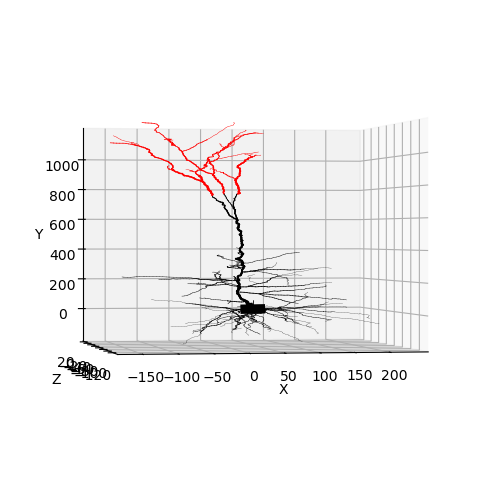

Plotting nexus:


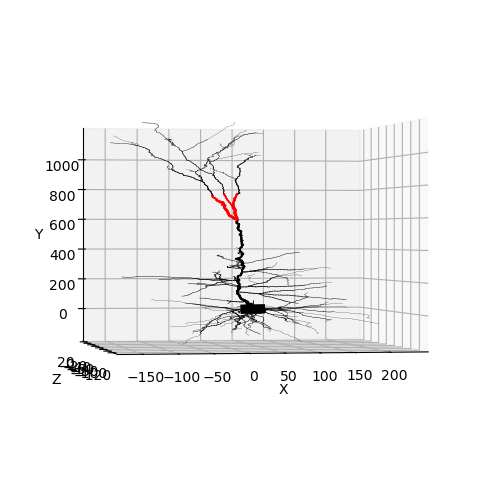

Plotting trunk:


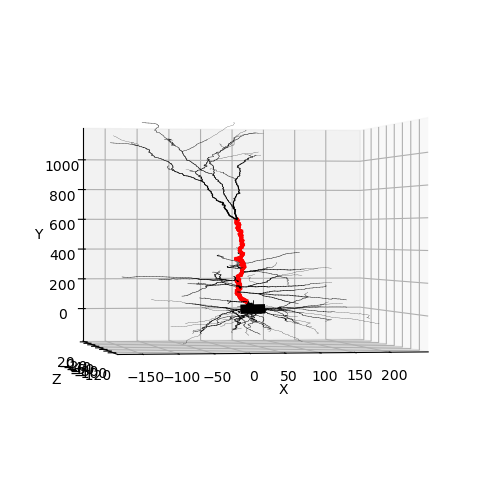

Plotting oblique:


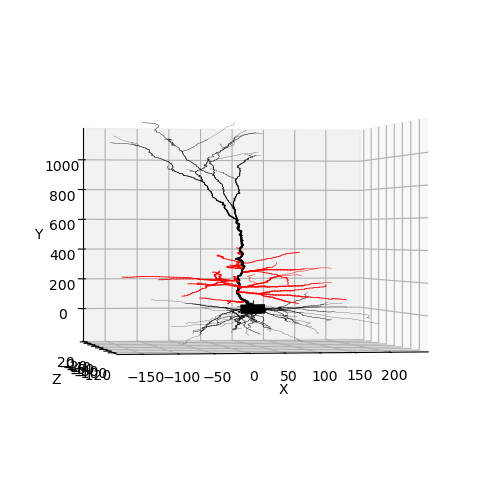

Plotting distal_basal:


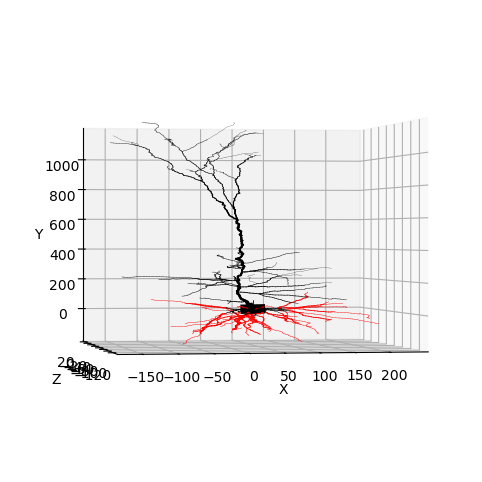

Plotting perisomatic:


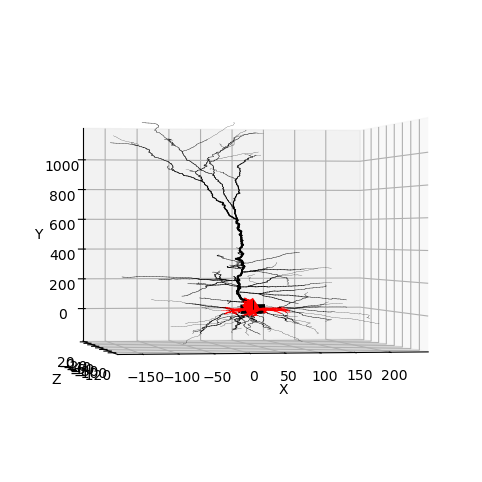

In [20]:
from Modules.plot_morphology import plot_morphology_flex

# Highlight all section typeS (keys of parameters.inh_syn_properties), each in its own plot. (USEFUL FOR DEBUGGING)
figs, axs = plot_morphology_flex(
    seg_data,
    option='each_sec_type',
    parameters=parameters,
    out_dir='plots/morphology'
)

# # Highlight a set of types in one plot with different colors
# figs, axs = plot_morphology_flex(
#     seg_data,
#     option='specific_sec_type',
#     sec_types=['perisomatic', 'distal_basal', 'distal_apical'],
#     out_dir='plots/morphology'
# )

# # Highlight a specific section type in one plot
# figs, axs = plot_morphology_flex(
#     seg_data,
#     option='single_type',
#     sec_types='nexus',
#     out_dir='plots/morphology'
# )

# # Highlight a specific section type in one plot with y-axis range specified
# figs, axs = plot_morphology_flex(
#     seg_data,
#     option='y_range',
#     y_min=685, y_max=885,
#     out_dir='plots/morphology'
# )

# In the event that automation is not successful, we can deal with overlapping precise section types using the `overlaps` dictionary from the segments file.
# ### OVERLAPPING PRECISE SEC TYPE LABELS TODO: (pull overlaps from generate_segments_csv if there are overlaps)
# # overlapping_seg_ids = [i for i,j in overlaps.items()]

## Generate Synapses.csv

This part generates a synapses.csv for that will hold the synapses that will be used for simulation.

The csv will be located at Neural-Modeling/simulations/{sims_dir}/{sim_dir}/synapses.csv.

Each row is one synapse.

Each column defines the properties of the synapse.

The section afterward we will add the spike_train column to this csv.

### Synapses 

Synapse design is mainly specified by parameters.{inh or exc}_syn_properties (check constants.py for exc_syn_properties for example)

### synapses.csv Columns

 Name ( {exc_or_inh} _ {sec_type} _ {id} ) (name)

 Location (seg_id)

 Weight (initW, gbar_{}, etc.)

 Release Probability (P_0)

 Modfile (modfile) modfiles are stored in Neural-Modeling/modfiles/hay/ (or some others)

 other default syn params (cell2cell_type) defined in Neural-Modeling/Modules/synapse.py

 ### Locations

 By default, synapses are placed uniformly [with specified density: (# / surface area) or (# / length)] by randomly placing them on segments with probabilities according to segment length or surface area. The total number of synapses will be calculated from the total length or surface area.

 These densities/numbers are specified by the user according to section type in parameters.{inh or exc}_syn_properties.
 
 Alternatively, the number of synapses can be provided instead of the density, and they will be spread uniformly according to segment probabilities (for consistent # per length or # per surface area).

 ### Synaptic weights, release probability, etc.

 The synaptic weight and release probability of each synapse is randomly sampled from distributions specified by section type in parameters.{inh or exc}_syn_properties.  

 ### Synapse modfiles

 Synapse modfiles are specified in Modules/constants.py as exc_syn_mod and inh_syn_mod (subject to change to co-locate with other properties).

 Note that different modfiles have different names for their variables so new modfiles will need to have their current and weight variables listed as 'modfile': '{var_name}' in the dictionaries syn_params_map and current_type_map of Modules.synapse.py.




In [21]:
# generate synapse objects abstractly. store info in csv.
from Modules.synapses_file import PreSimSynapseGenerator

# create PreSimSynapseGenerator instance and generate synapse locations, weights, etc.
# everything except presynaptic spike trains.
pssg = PreSimSynapseGenerator(sim_dir)
pssg.generate_synapse_locations()
pssg.synapses.to_csv(os.path.join(sim_dir, "synapses.csv"), index=False)

NEURON: The user defined name already exists: AMPA_NMDA
 near line 0
 {gCa_HVAbar_Ca_HVA(1.0000000000) = 0.0000555000}
                                                 ^
        nrn_load_dll("../scripts...")


In [22]:
# # view synapses from synapses csv
synapses = pd.read_csv(os.path.join(sim_dir, "synapses.csv"))
synapses.head() # show the first few lines of synapses

# tooltip: P_0 is release probability, initW is the initial weight multiplier,
# gbar_ampa and gbar_nmda are the excitatory synapse conductances,
# gbar_gaba is the inhibitory synapse conductance
# seg_id is the segment ID where the synapse is located

,name,modfile,P_0,initW,cell2cell_type,seg_id,gbar_ampa,gbar_nmda,gbar_gaba
0,exc_tuft_0,pyr2pyr,0.354387,1.548931,PN2PN,2023,0.00159,0.001868,NaN
1,exc_tuft_1,pyr2pyr,0.686850,1.683359,PN2PN,1638,0.00159,0.001868,NaN
2,exc_tuft_2,pyr2pyr,0.379372,1.416896,PN2PN,2140,0.00159,0.001868,NaN
3,exc_tuft_3,pyr2pyr,0.000000,1.761343,PN2PN,2085,0.00159,0.001868,NaN
4,exc_tuft_4,pyr2pyr,0.990291,1.251326,PN2PN,1720,0.00159,0.001868,NaN


## Spike Trains

Spike train properties are defined by parameters.{exc or inh}_syn_properties of Neural-Modeling/Modules/constants.py. Mean firing rate distributions are defined in the post_init function.

### Add spike trains to synapses.csv

Presynaptic spike times for this synapse (spike_train)

Mean firing rate of the presynaptic (pc_mean_firing_rate)

Functional group (FG) ID, denoting synapses that are correlated at the functional group level. (functional_group), -1.0 for no FG.

Presynaptic cell (PC) ID, denoting synapses that belong to a certain PC within this FG, -1.0 for no PC.

### Background Synapses

Background synapse is the default setting, these synapses recieve their own randomly generated spike train with mean firing rate (and constant firing rate timecourse (constant through time)) from the distribution associated with the synapse's location.

### Presynaptic Cell Assemblies (clusters): Functional Groups (FGs) and Presynaptic Cells (PCs)

To model inputs from cell assemblies we use FGs to resemble regions and PCs to resemble cells themselves.

You can specify the center and radius of each FG and then the center and radius for each PC within the FG. For systematically or randomly generating lots of FGs and PCs, it is recommended to create another script (example clusters.py)

PCs within a FG will share a modulatory firing rate timecourse unique to the PC's FG (mean_fr=1, rhythmic or noisy through time).

PCs will have their own mean firing rate (sampled from mu, sigma), multipled with their FG's firing rate time course.

Then for each PC, Poisson is sampled for each time in their firing rate timecourse to calculate a spike train that goes to all synapses belonging to that PC.



In [23]:
# adds column spike_train according to parameters.
pssg.generate_spike_trains_for_synapses()
# simulator.run_on_all_sims(simulator.sims_dir, use_pssg, pssg_function_name= 'generate_spike_trains_for_synapses') #TODO: fix

In [24]:
# view updated synapses now having spike_train column
synapses = pd.read_csv(os.path.join(sim_dir, "synapses.csv"))
synapses.head() # show the csv

,name,modfile,P_0,initW,cell2cell_type,seg_id,gbar_ampa,gbar_nmda,gbar_gaba,spike_train,pc_mean_firing_rate,functional_group,presynaptic_cell
0,exc_tuft_0,pyr2pyr,0.354387,1.548931,PN2PN,2023,0.00159,0.001868,NaN,[ 2 20 143 1038 1060 1243 1319 32...,2.521061,-1.0,-1.0
1,exc_tuft_1,pyr2pyr,0.686850,1.683359,PN2PN,1638,0.00159,0.001868,NaN,[ 67 422 492 642 791 1007 1046 10...,7.466319,-1.0,-1.0
2,exc_tuft_2,pyr2pyr,0.379372,1.416896,PN2PN,2140,0.00159,0.001868,NaN,[ 174 201 392 555 563 1175 1282 13...,8.573821,-1.0,-1.0
3,exc_tuft_3,pyr2pyr,0.000000,1.761343,PN2PN,2085,0.00159,0.001868,NaN,[ 26 357 526 684 697 806 944 13...,3.333755,-1.0,-1.0
4,exc_tuft_4,pyr2pyr,0.990291,1.251326,PN2PN,1720,0.00159,0.001868,NaN,[ 109 430 446 573 909 1004 1196 12...,2.719443,-1.0,-1.0


### Visualizations of Designed Synapses

#### PCs and FGs

In [25]:
# parameters.exc_clustering # view the setup

In [26]:
# parameters.inh_clustering # view the setup

In [ ]:
from Modules.synapse_analysis import SynapseAnalyzer

# Initialize the analyzer with your simulation directory
synapse_analyzer = SynapseAnalyzer(sim_dir)
synapse_analyzer.add_segment_data()

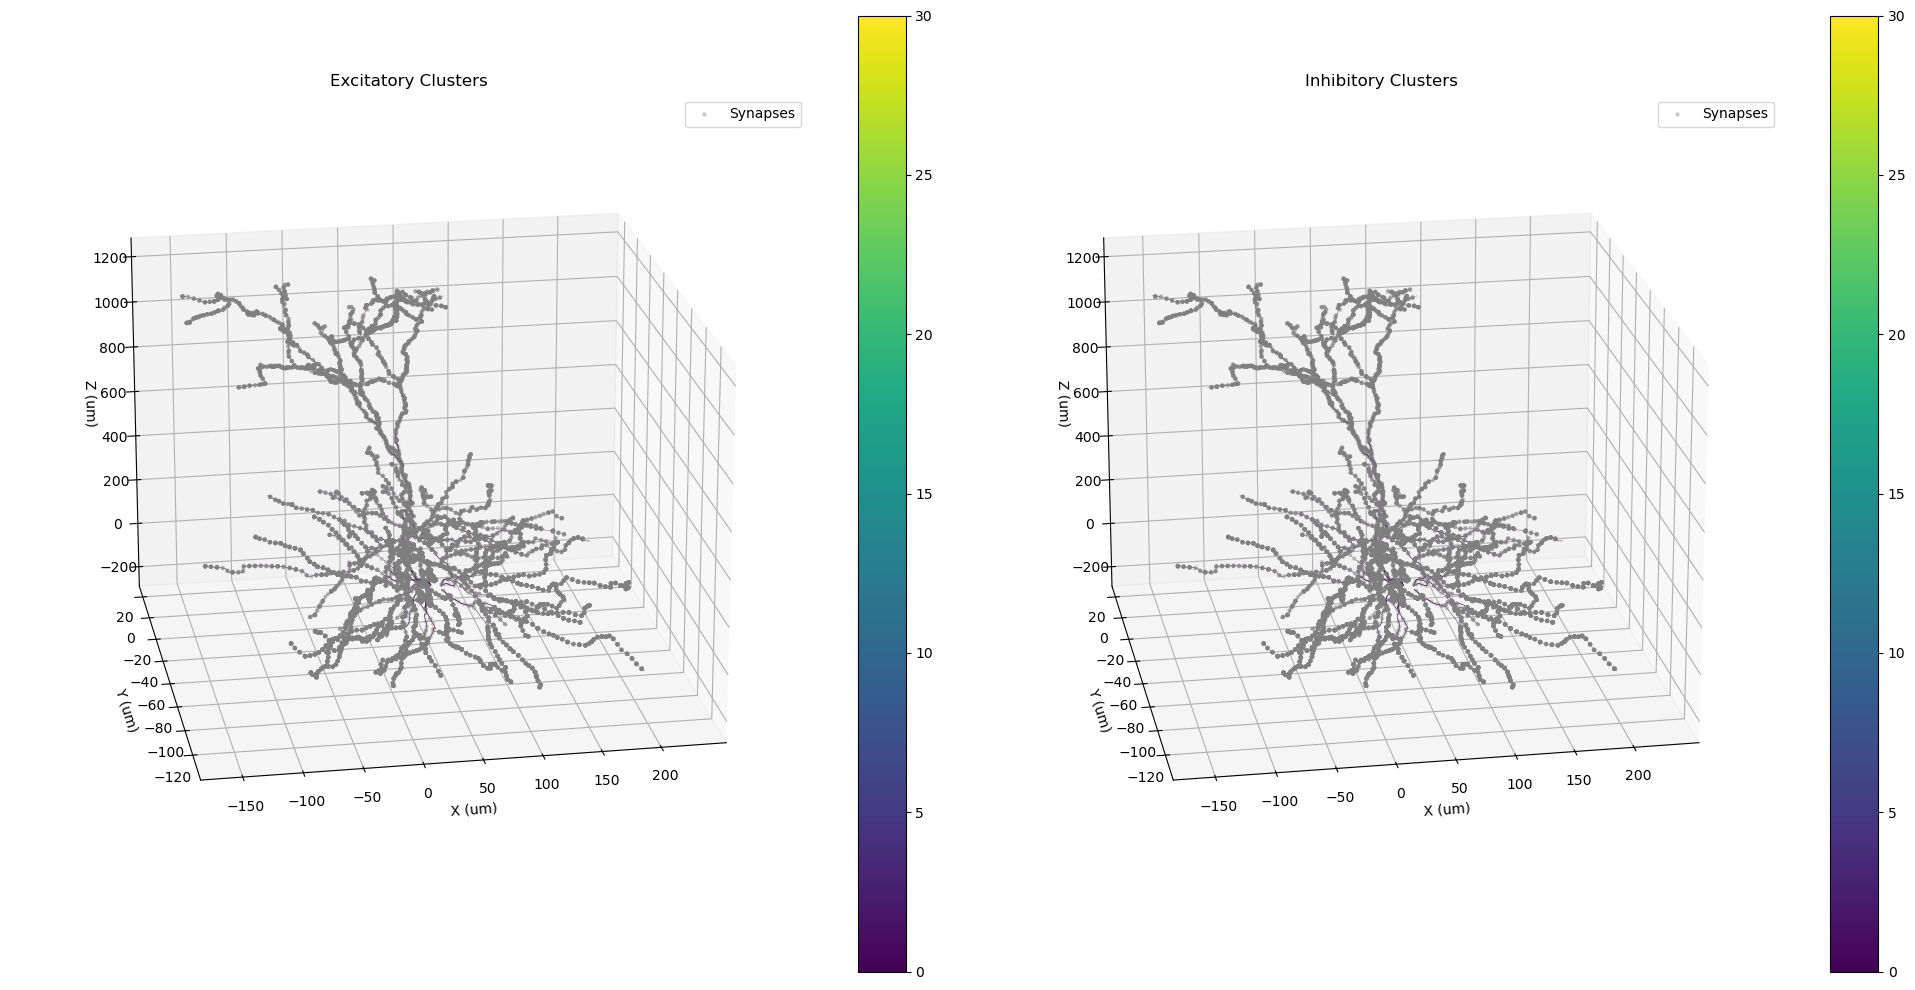

In [ ]:
# plot the synapse clusters
synapse_analyzer.plot_all_synapse_clusters(
    plot_both_together=True,
    plot_each_type_separately=True
)

## Further synapse design analysis (Spike raster, etc.) (To be finished)

In [ ]:
# Get statistics for a specific functional group
if len(parameters.exc_clustering) > 0: # number of excitatory clusters
    stats = synapse_analyzer.analyze_cluster_statistics(
        functional_group_id=0,
        synapse_type='exc'
    )
    print(f"stats for exc cluster group {0}: {stats}")

In [ ]:
# # Generate a spike raster plot for excitatory synapses
# synapse_analyzeranalyzer.plot_spike_raster(
#     synapse_types=['exc'],
#     time_window=(0, 1000),  # First second of simulation
#     save_path=os.path.join(sim_dir, 'spike_raster.png')
# )

## Copy over the sim_dir to notebooks/AA_sim.ipynb then notebooks/AA_post_sim.ipynb for simulation and analysis.

In [ ]:
os.path.abspath(sim_dir) # for copying over

Next, we need to simulate based on this folder. If you are in Colab then you will need to download the simulation folder or mount your drive and work through there 

### proceed to Neural-Modeling/notebooks/AA_sim.ipynb